create a pytorch Dataset from MVS10015 Dataset
pytorch [documentaion](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
# Create train/test split (80%)/(20%):
import os
import shutil
import math
import random

source_folder = 'Data/HAM100000_images/'
test_folder = 'Data/HAM100000_images_test/'
train_folder = 'Data/HAM100000_images_train/'

file_list = os.listdir(source_folder)

number_test_images = math.ceil(0.2 * len(file_list))
number_train_images = len(file_list) - number_test_images
# TODO: Set manual seed and select number_test_images in and rest in 'Data/HAM100000_images_train' 
seed_value = 42
random.seed(seed_value)

random_numbers = set()

while len(random_numbers) <= number_test_images:
    random_numbers.add(random.randint(0, len(file_list)-1))

for index, file in enumerate(file_list):
    if index in random_numbers:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(train_folder, file)
        shutil.copy(source_path, destination_path)
    else:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(test_folder, file)
        shutil.copy(source_path, destination_path)

In [45]:
# Create annotations file for given train/test split

import csv
import os

test_directory = 'Data/HAM100000_images_test/'

with open('Data/HAM10000_labels.csv') as file:
    csv_reader = csv.reader(file)

    print(next(csv_reader)[0])
    write_test = []
    write_train = []

    for row in csv_reader:
        path_image = os.path.join(test_directory, row[0])
        path_image = path_image + '.jpg'
        if os.path.isfile(path_image):
            write_test.append([row[0], row[1]])
        else:
            write_train.append([row[0], row[1]])
    
with open('Data/HAM100000_train_label.csv', 'w', newline='') as file:
    csv_writer = csv.writer(file)
    for row in write_train:
        csv_writer.writerow(row)


with open('Data/HAM100000_test_label.csv', 'w', newline='') as file:
    csv_writer = csv.writer(file)
    for row in write_test:
        csv_writer.writerow(row)

image_id


In [74]:
import torch
from skimage import io
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

class ImageDataset(Dataset):
    def __init__(self, csv_annotation, root_dir, transform=None):
        
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_annotation)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.frame.iloc[idx, 0])
        image_name = image_name + '.jpg'
        image = io.imread(image_name)

        sample = {'image': image, 'label': self.frame.iloc[idx, 1]}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

    

In [39]:
import os
from PIL import Image
import pandas as pd

root = 'Data\HAM100000_images'
frame = pd.read_csv('Data\HAM10000_labels.csv')

image_path = os.path.join(root, frame.iloc[0,0])
image_path = image_path + '.jpg'
with Image.open(image_path) as image:
    image.show()

print(image_path)


Data\HAM100000_images\ISIC_0027419.jpg


bkl


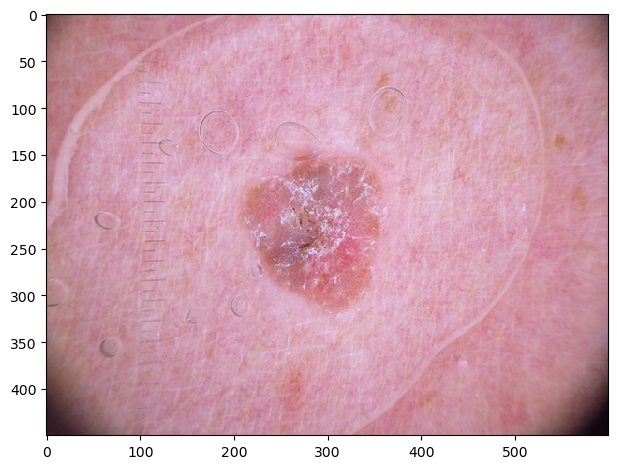

In [79]:
# load data into pytorch dataset and test ImageDatset

training_data = ImageDataset(csv_annotation='Data/HAM100000_train_label.csv', root_dir='Data/HAM100000_images_train/')
test_data = ImageDataset(csv_annotation='Data/HAM100000_test_label.csv', root_dir='Data/HAM100000_images_test/')

seed_value = 42
random.seed(seed_value)

ind = random.randint(0, len(os.listdir('Data/HAM100000_images_train/')))

sample = training_data[ind]
io.imshow(sample['image'])
print(sample['label'])

In [76]:
# load data
import random

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)


